In [1]:
import cv2
import numpy as np
import tqdm.notebook as tqdm
import glob
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm, classification_report as cr

%matplotlib inline

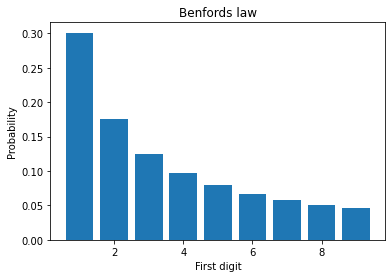

In [2]:
x = np.arange(1, 10)
benford = np.log10(1 + 1 / x)
plt.bar(x, benford)
plt.title('Benfords law')
plt.xlabel('First digit')
plt.ylabel('Probability')
plt.show()
plt.close()

In [3]:
def tamper_image(image, k=31):
    image = cv2.medianBlur(image, k)
    return image

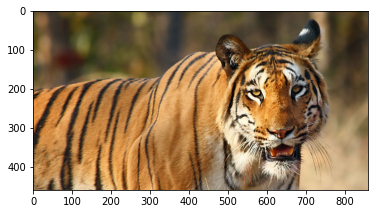

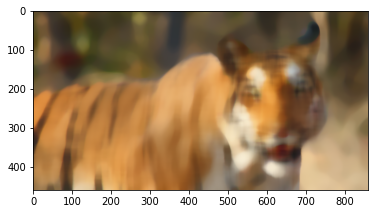

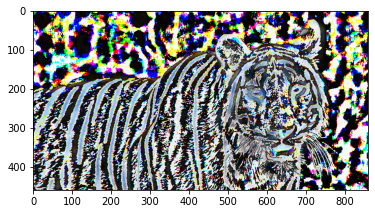

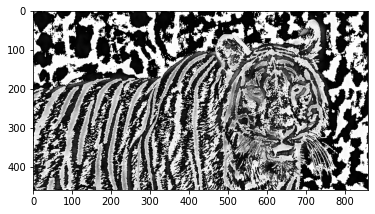

In [4]:
image = cv2.imread('Desktop/input/compare-difference-bw-lepord-and-tiger/compare lepord and tiger/train/tiger/033019_SZ_reviews_feat.jpg')
plt.imshow(image[:, :, ::-1])
plt.show()

double = tamper_image(image)
plt.imshow(double[:, :, ::-1])
plt.show()

plt.imshow((image - double)[:, :, ::-1])
plt.show()

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) - cv2.cvtColor(double, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.show()
plt.close()

In [5]:
def compute_first_digits(img, normalise=False, debug_dct=False):
    if isinstance(img, str):
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        
    if len(img.shape) == 3 :
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if normalise:
        norm = cv2.normalize(img, np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX)
        
    dct = cv2.dct(np.float32(img) / 255.0)
    dct = np.abs(dct)  # Take abs values
    if debug_dct:
        print(dct)

    min_val = dct.min()
    if min_val < 1:
        dct = np.power(10, -np.floor(np.log10(min_val)) + 1) * dct  # Scale all up to remove leading 0.00s
    
    if not (dct >= 1.0).all():
        raise ValueError("Error")
    
    digits = np.log10(dct).astype(int).astype('float32')
    first_digits = dct / np.power(10, digits)
    first_digits[(first_digits < 1.0) & (first_digits > 0.9)] = 1  # Handle edge case.
    first_digits = first_digits.astype(int)
    
    if not (first_digits >= 1).all() and (first_digits <= 9).all():
        raise ValueError("Error")

    return first_digits


def compute_first_digits_counts(img, normalise=False):
    first_digits = compute_first_digits(img, normalise=normalise)
    unq, counts = np.unique(first_digits, return_counts=True)
    return unq, counts


# Small test
rnd = np.random.uniform(size=(4, 4)) * 255
compute_first_digits(rnd.astype('uint8'), debug_dct=True)

[[1.7911766  0.14741904 0.2107843  0.36871043]
 [0.33038345 0.12474624 0.38865936 0.1649423 ]
 [0.11078429 0.31907627 0.00882353 0.5746731 ]
 [0.2929241  0.17474626 0.09413431 0.21494235]]


array([[1, 1, 2, 3],
       [3, 1, 3, 1],
       [1, 3, 8, 5],
       [2, 1, 9, 2]])

In [6]:
def prototype_image(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(img, cmap='gray')
    plt.show()

    first_digits = compute_first_digits(img)
    plt.imshow(first_digits)
    plt.show()

    unq, counts = np.unique(first_digits, return_counts=True)
    tot = counts.sum()
    counts = counts / tot
    plt.plot(unq, counts, color='red', marker='x', linestyle='dashed', linewidth=2, markersize=12)
    plt.bar(unq, benford, color='blue')
    plt.show()
    plt.close()

    print(stats.chisquare(counts, benford))

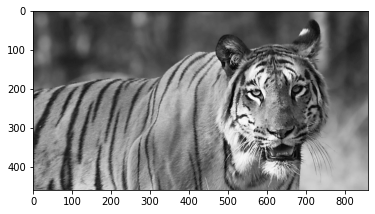

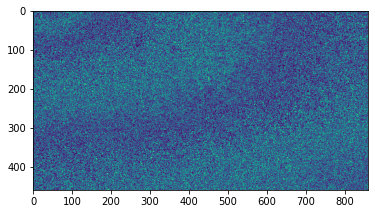

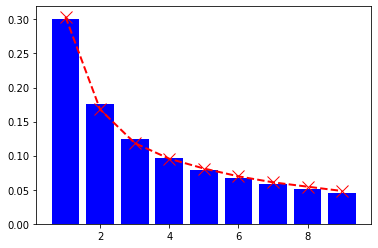

Power_divergenceResult(statistic=0.0013991443552577511, pvalue=0.99999999999999)


In [7]:
prototype_image(image)

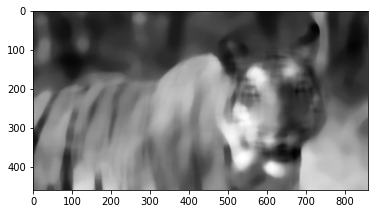

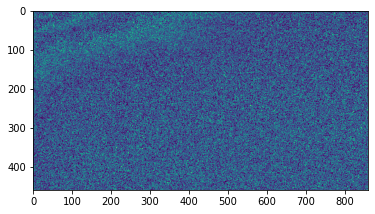

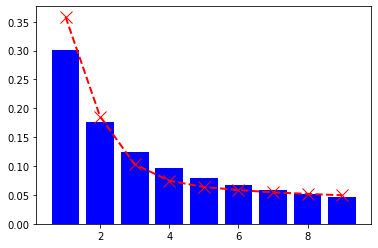

Power_divergenceResult(statistic=0.02510020664329035, pvalue=0.9999999989766634)


In [8]:
prototype_image(double)

In [9]:
reference = sorted(glob.glob('../input/compare-difference-bw-lepord-and-tiger/compare lepord and tiger/*/*/*.jpg'))
counts_ref = np.array([compute_first_digits_counts(x)[1] for x in tqdm.tqdm(reference)])
counts_mod = np.array([compute_first_digits_counts(tamper_image(cv2.imread(x, cv2.IMREAD_GRAYSCALE)))[1] for x in tqdm.tqdm(reference)])

counts_ref_norm = counts_ref / counts_ref.sum(axis=1)[..., np.newaxis]
counts_mod_norm = counts_mod / counts_mod.sum(axis=1)[..., np.newaxis]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

In [10]:
print(counts_ref_norm.mean(axis=0) - benford)
print(counts_mod_norm.mean(axis=0) - benford)

[-3.35829456e-03  2.21901279e-04  1.44652684e-03  1.10975234e-03
  6.88152238e-04  3.28592862e-04  8.28067078e-05 -1.48420847e-04
 -3.71016858e-04]
[ 0.04555572  0.01451737 -0.01349296 -0.01800829 -0.01389496 -0.0091055
 -0.00483306 -0.00151181  0.00077349]


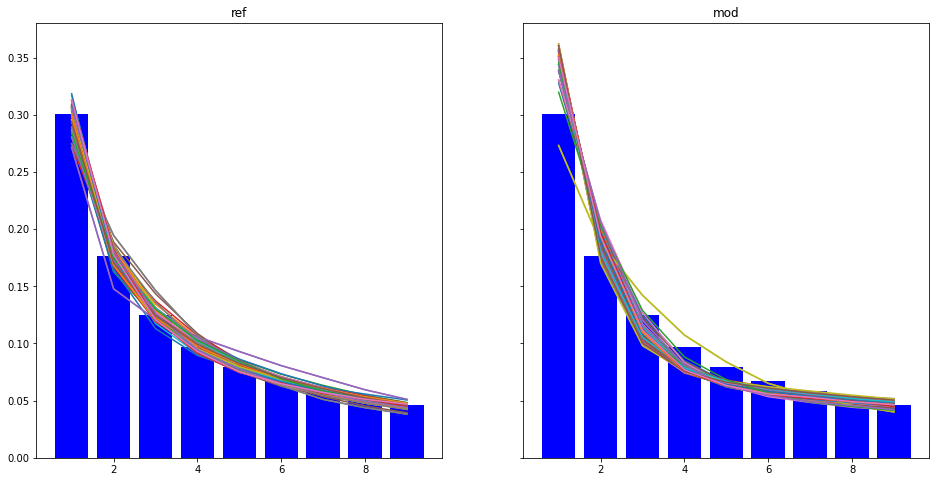

In [11]:
x = np.arange(1, 10)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
ax1.set_title('ref')
ax2.set_title('mod')
ax1.bar(x, benford, color='blue')
ax2.bar(x, benford, color='blue')
for r, m in zip(counts_ref_norm, counts_mod_norm):
    ax1.plot(x, r)
    ax2.plot(x, m)

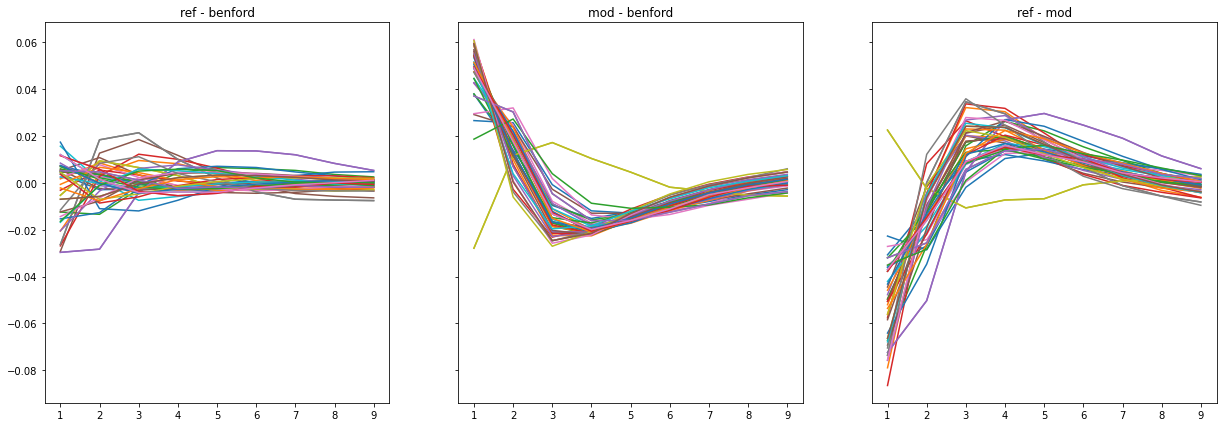

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7), sharex=True, sharey=True)
ax1.set_title('ref - benford')
ax2.set_title('mod - benford')
ax3.set_title('ref - mod')
x = np.arange(1, 10)
for r, m in zip(counts_ref_norm, counts_mod_norm):
    ax1.plot(x, r-benford)
    ax2.plot(x, m-benford)
    ax3.plot(x, r-m)

In [13]:
chi2_ref = [stats.chisquare(counts, benford) for counts in counts_ref_norm]
chi2_ref_stat, chi2_ref_p = zip(*chi2_ref)
print(np.mean(chi2_ref_stat), np.mean(chi2_ref_p))

chi2_mod = [stats.chisquare(counts, benford) for counts in counts_mod_norm]
chi2_mod_stat, chi2_mod_p = zip(*chi2_mod)
print(np.mean(chi2_mod_stat), np.mean(chi2_mod_p))

0.002803428456128813 0.9999999999849833
0.020543206563218324 0.999999999430839


In [14]:
x = np.concatenate([counts_ref_norm, counts_mod_norm])
y = np.concatenate([[0 for _ in counts_ref_norm], [1 for _ in counts_mod_norm]])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)

rf = RandomForestClassifier(random_state=0).fit(x_train, y_train)

y_pred = rf.predict(x_train)
print(cm(y_true=y_train, y_pred=y_pred))
print(cr(y_true=y_train, y_pred=y_pred))

y_pred = rf.predict(x_test)
print(cm(y_true=y_test, y_pred=y_pred))
print(cr(y_true=y_test, y_pred=y_pred))

[[33  0]
 [ 0 32]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        32

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65

[[14  0]
 [ 0 15]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        15

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



# Trying on photoshopped dataset

In [15]:
N = 200
reference = sorted(glob.glob('../input/photoshopped-faces/reference/*.png'))[:N]
modified = sorted(glob.glob('../input/photoshopped-faces/modified/*.png'))[:N]

In [16]:
counts_ref = np.array([compute_first_digits_counts(x)[1] for x in tqdm.tqdm(reference)])
counts_mod = np.array([compute_first_digits_counts(x)[1] for x in tqdm.tqdm(modified)])

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [17]:
counts_ref_norm = counts_ref / counts_ref.sum(axis=1)[..., np.newaxis]
counts_mod_norm = counts_mod / counts_mod.sum(axis=1)[..., np.newaxis]

In [18]:
print(counts_ref_norm.mean(axis=0) - benford)
print(counts_mod_norm.mean(axis=0) - benford)
print(counts_ref_norm.mean(axis=0) - counts_mod_norm.mean(axis=0))

[-0.00053013  0.00222177  0.00118962  0.0001887  -0.00040901 -0.000688
 -0.00076505 -0.00067333 -0.00053457]
[ 0.00024546  0.00081957  0.00031622 -0.00011779 -0.00021828 -0.0003021
 -0.0002936  -0.00023505 -0.00021444]
[-0.00077559  0.0014022   0.0008734   0.00030649 -0.00019073 -0.0003859
 -0.00047146 -0.00043828 -0.00032012]


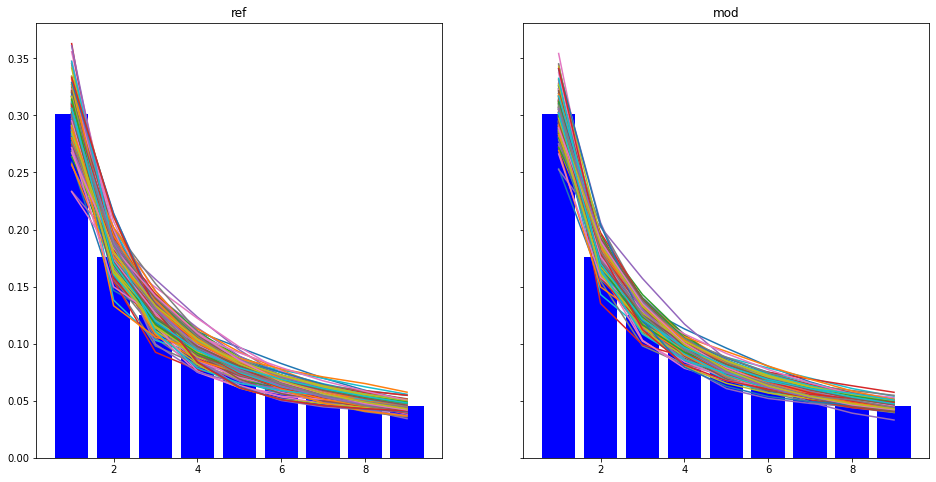

In [19]:
x = np.arange(1, 10)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
ax1.set_title('ref')
ax2.set_title('mod')
ax1.bar(x, benford, color='blue')
ax2.bar(x, benford, color='blue')
for r, m in zip(counts_ref_norm, counts_mod_norm):
    ax1.plot(x, r)
    ax2.plot(x, m)

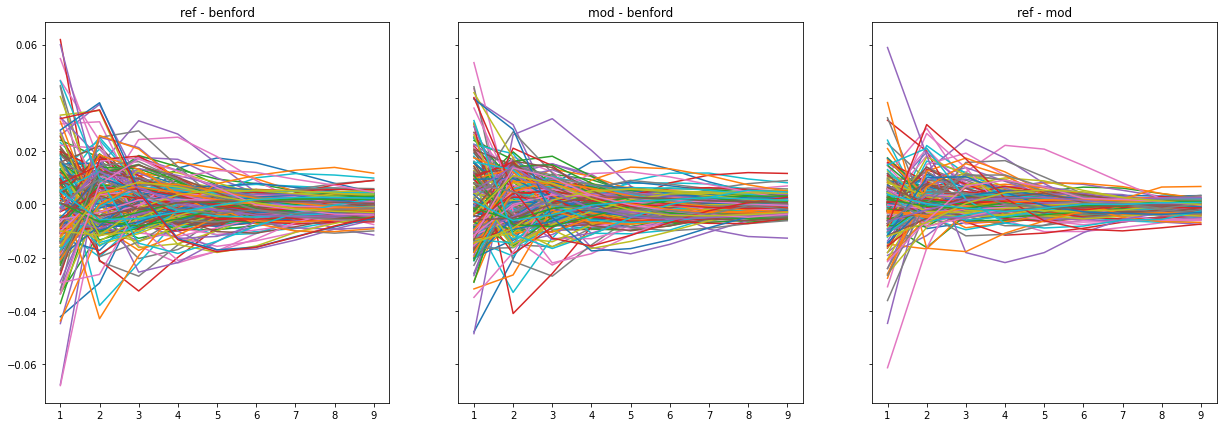

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7), sharex=True, sharey=True)
ax1.set_title('ref - benford')
ax2.set_title('mod - benford')
ax3.set_title('ref - mod')
x = np.arange(1, 10)
for r, m in zip(counts_ref_norm, counts_mod_norm):
    ax1.plot(x, r-benford)
    ax2.plot(x, m-benford)
    ax3.plot(x, r-m)

In [21]:
chi2_ref = [stats.chisquare(counts, benford) for counts in counts_ref_norm]
chi2_ref_stat, chi2_ref_p = zip(*chi2_ref)
print(np.mean(chi2_ref_stat), np.mean(chi2_ref_p))

chi2_mod = [stats.chisquare(counts, benford) for counts in counts_mod_norm]
chi2_mod_stat, chi2_mod_p = zip(*chi2_mod)
print(np.mean(chi2_mod_stat), np.mean(chi2_mod_p))

0.005378567202422428 0.9999999998788156
0.0038633311841170426 0.9999999999588883


In [22]:
x = np.concatenate([counts_ref_norm, counts_mod_norm])
y = np.concatenate([[0 for _ in counts_ref_norm], [1 for _ in counts_mod_norm]])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=0, shuffle=True)

rf = RandomForestClassifier(random_state=0).fit(x_train, y_train)

y_pred = rf.predict(x_train)
print(cm(y_true=y_train, y_pred=y_pred))
print(cr(y_true=y_train, y_pred=y_pred))

y_pred = rf.predict(x_test)
print(cm(y_true=y_test, y_pred=y_pred))
print(cr(y_true=y_test, y_pred=y_pred))

[[132   0]
 [  1 135]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       132
           1       1.00      0.99      1.00       136

    accuracy                           1.00       268
   macro avg       1.00      1.00      1.00       268
weighted avg       1.00      1.00      1.00       268

[[29 39]
 [38 26]]
              precision    recall  f1-score   support

           0       0.43      0.43      0.43        68
           1       0.40      0.41      0.40        64

    accuracy                           0.42       132
   macro avg       0.42      0.42      0.42       132
weighted avg       0.42      0.42      0.42       132



On photoshopped images, this check doesn't work as well as i'd have hoped.